In [10]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import math
from textblob import TextBlob
# from better_profanity import profanity

# Nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [12]:
# borrowed from stackoverflow https://stackoverflow.com/a/49146722
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def remove_unwanted(document):

    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove emoji's
    document = remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  ',"")
    
    return document.strip()

In [13]:
def lemmatize_text(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    
    lemmatized_sentence = " ".join(lemma_list)
    return lemmatized_sentence

In [14]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [15]:
data = pd.read_csv("Harvey_stressor.csv")

exclusive_emotion = ["approval","desire","admiration","love","gratitude","excitement","optimism","joy","amusement","neutral"]
extracted_data = data.loc[~data["Emotion"].isin(exclusive_emotion)].reset_index()

extracted_data['Tweet']=extracted_data['Tweet'].astype(str)

text_corpus = extracted_data["Tweet"].astype(str)
len(text_corpus)

98229

In [16]:
text_corpus

0        As Hurricane Harvey is fast approaching now is...
1        If youre able give blood at RedCrossDonate blo...
2        Lifethreatening Hurricane Harvey head toward T...
3        Daddy please get out of the way of HurricaneHa...
4        Everyone please pray for Texas Hurricane Harve...
                               ...                        
98224     How You Can Help the Victims of Hurricane Harvey
98225         Hurricane Harvey How to help in time of need
98226    To everyone affected by Hurricane Harvey send ...
98227    Our thought are with our neighbor in the South...
98228    Marylanders head to Texas to assist with Hurri...
Name: Tweet, Length: 98229, dtype: object

### This section is for expansion purpose

In [17]:
# climate_data = []
# vocab = ["climate","warming","global","change","carbon","pollution","greenhouse","energy","fossil","fuel","hoax"]
# words_re = re.compile("|".join(vocab))

# for tweet in text_corpus:
#     if words_re.search(tweet):
#         climate_data.append(tweet)

# len(climate_data)

In [18]:
new_corpus = []

for text in text_corpus:

    clean_text = remove_unwanted(str(text))
    clean_text = ' '.join([w for w in clean_text.split() if len(w)>1])
    clean_text = lemmatize_text(clean_text)
    new_corpus.append(clean_text)

# new_corpus = np.array(new_corpus)

In [19]:
new_corpus

['As Hurricane Harvey be fast approach now be the time to do what you can to prepare your property to minimize',
 'If youre able give blood at RedCrossDonate blood time money skillsHurricane Harvey be bad oneunite help serve',
 'Lifethreatening Hurricane Harvey head toward Texas coastx000D pictwittercom8R18AJKuYf',
 'Daddy please get out of the way of HurricaneHarvey need you safe',
 'Everyone please pray for Texas Hurricane Harvey be nearly category storm and it go to hover there for at least three day',
 'Hi Maria Will Bush AirportHobby Expect SuperStorm Sandys Storm Surge with Hurricane Harveypictwittercomt8oVNqDxkp',
 'Praying for Corpus ChristiHoustonHurricaneHarvey',
 'For all of you in HurricaneHarvey territory hope you find way to stay safe Ill keep you all in my thought',
 'To everyone in TexasPlease get to safety and if your stay put get to safetyHurricaneHarvey',
 'Texans Told to Evacuate Ahead of Hurricane Harvey Massive Storm Approaches Dont Take Any Chances',
 'Going to M

In [20]:
# clean_tweet_data = np.array(new_corpus)
# extracted_data["Tweet"] = clean_tweet_data
# extracted_data.to_csv('Harvey_stressor.csv',index=False)

In [21]:
stop_words = stopwords.words('english')

extended_words = ["hes","ur","le","ta","tf","yo","couldnt","wasnt","along","ago","someone","literally","absolutely","probably","seem","hasnt","surround","though",
                "toward","suppose","ya","let","bc","texashurricaneharvey","hurricaneharvey2017","newshurricane","hurricaneharveys","hurricaneharvey","great",
                "safehurricaneharvey","include","havent","joe","word","hurricane","harvey","texas","austin","galveston","storm","winds","houston","david","usa",
                "twitter","donald","trump","trumps","san","hey","houstons","southeast","tomorrow","else","potus","harveys","texans","via","wind","tx","harvey2017", 
                "corpus","christi","harveys","mph","category","cat","gulf","coast","hurricanharvey","category4","x000dhurricaneharvey","x000dhurricanharvey","ha",
                "wa","130","harveyx000d","hurricaineharvey","x000d","antonio","harveystay","mexico","2017","louisiana","corpuschristi", "florida", "130mph"]

stop_words.extend(extended_words)

In [22]:
tokenizer = RegexpTokenizer(r'\w+')

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize,
                        max_features=500,
                        encoding='utf-8')

train_data = tfidf.fit_transform(new_corpus)


c:\Users\boko1\anaconda3\envs\harvey_p39_env\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names_out()
top_n = 50
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['party', 'hold', 'track', 'forecaster', 'calm', 'event', 'consider', 'office', 'team', 'respond', 'fire', 'everyones', 'early', 'mile', 'positive', 'stick', 'refuse', 'imagine', 'foot', '10', 'bbc', 'snapchat', 'service', 'sustained', 'food', 'scared', 'strength', 'administration', 'alligator', 'ban', 'horrible', 'drown', 'inch', 'government', 'pls', 'barrel', 'sustain', 'nature', 'potential', 'prayersfortexas', 'able', 'important', 'assist', 'play', 'build', 'fly', 'saturday', 'problem', 'others', 'heed']


In [24]:
# Materialize the sparse data
data_dense = train_data.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7735230939946451 %


## SAMPLE LDA

In [25]:
warnings.filterwarnings('ignore')
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations  
                                      random_state=100,          # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(train_data)

pprint(lda_model)  # Model attributes

LatentDirichletAllocation(n_components=20, n_jobs=-1, random_state=100)


In [26]:
avg_coherence = get_average_topic_coherence(train_data, lda_model.components_, 10)
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(train_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(train_data))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1234032.7308353235
Perplexity:  970.1839339167352
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## GridSearch LDA

In [27]:
# # Define Search Param
topic_number = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125]
# decay_rate = [0.5, 0.7, 0.9]
coherence_score = []
for i in topic_number:
    lda_model = LatentDirichletAllocation(n_components=i,            # Number of topics
                                        learning_decay= 0.7,
                                        max_iter=10,               # Max learning iterations  
                                        random_state=100,          # Random state
                                        evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                        n_jobs = -1,               # Use all available CPUs
                                        )
    lda_output = lda_model.fit_transform(train_data)
    coherence_score.append(get_average_topic_coherence(train_data, lda_model.components_, 25))
    print("LDA model with "+str(i)+" topics is done!")
        
coherence_score = np.array(coherence_score)

LDA model with 20 topics is done!
LDA model with 25 topics is done!
LDA model with 30 topics is done!
LDA model with 35 topics is done!
LDA model with 40 topics is done!
LDA model with 45 topics is done!
LDA model with 50 topics is done!
LDA model with 55 topics is done!
LDA model with 60 topics is done!
LDA model with 65 topics is done!
LDA model with 70 topics is done!
LDA model with 75 topics is done!
LDA model with 80 topics is done!
LDA model with 85 topics is done!
LDA model with 90 topics is done!
LDA model with 95 topics is done!
LDA model with 100 topics is done!
LDA model with 105 topics is done!
LDA model with 110 topics is done!
LDA model with 115 topics is done!
LDA model with 120 topics is done!
LDA model with 125 topics is done!


In [28]:
plotting_coherence = np.delete(coherence_score,0)
np.savetxt('coherence_score_with_lemma.out', coherence_score, delimiter=',')

In [29]:
plotting_coherence = np.loadtxt("coherence_score_with_lemma.out", dtype=float)

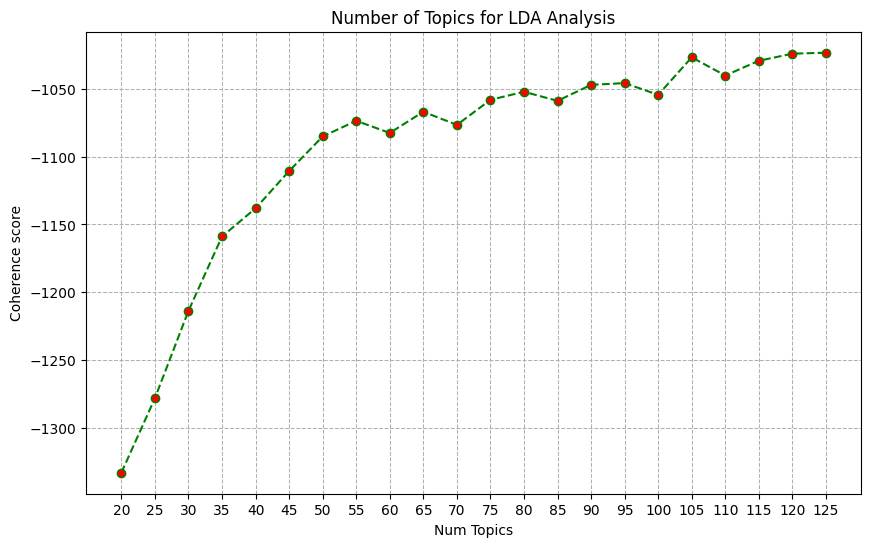

In [30]:
topics_no = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125]
plt.figure(figsize=(10,6))

plt.plot(topics_no,plotting_coherence, linestyle='--', marker='o', c='green', mfc='red')
plt.title("Number of Topics for LDA Analysis")
plt.xlabel("Num Topics")
plt.xticks([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125])

plt.ylabel("Coherence score")
plt.grid(which ='major',linestyle='--', linewidth=0.75)
plt.show()

In [31]:
plt.savefig('Number of Topics analysis.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

### LDA model with Optimal Topics number

In [47]:
topic_no = 55

In [48]:
lda_model = LatentDirichletAllocation(n_components=topic_no,            # Number of topics
                                    learning_decay= 0.7,
                                    max_iter=10,               # Max learning iterations  
                                    random_state=100,          # Random state
                                    evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                    n_jobs = -1,               # Use all available CPUs
                                    )
lda_output = lda_model.fit_transform(train_data)
pprint(lda_model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 55,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [49]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(train_data)

# column names
topicnames = ["Topic" + str(i) for i in range(topic_no)]

# index names
docnames = ["Doc" + str(i) for i in range(len(new_corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'white'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(30).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39,Topic40,Topic41,Topic42,Topic43,Topic44,Topic45,Topic46,Topic47,Topic48,Topic49,Topic50,Topic51,Topic52,Topic53,Topic54,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.420000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.230000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,4
Doc1,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.110000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.170000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.240000,0.220000,0.010000,0.010000,0.010000,0.010000,0.010000,48
Doc2,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.590000,54
Doc3,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.690000,0.010000,0.010000,0.010000,0.010000,0.010000,49
Doc4,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.390000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.180000,0.010000,0.150000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,11
Doc5,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.330000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.270000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,19
Doc6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.510000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,35
Doc7,0.000000,0.000000,0.000000,0.

In [50]:
extracted_data["Topic_number"] = np.array(dominant_topic)
extracted_data.to_csv('Harvey_stressor_with_topics.csv',index=False)


In [51]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,6373
1,17,5663
2,35,3743
3,24,3325
4,30,3228
5,50,2493
6,11,2486
7,22,2396
8,13,2219
9,18,2145


In [52]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()
lda_components = lda_model.components_
with open("Topic_term.txt", 'w') as f:
    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        line = "Topic "+str(index)+": "+str([w for w in top_terms_list])
        # print(line)
        f.write(line)
        f.write('\n')

In [53]:
cluster_no = lda_model.n_components

# Construct the k-means clusters
clusters = KMeans(n_clusters=cluster_no, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.13  0.09  0.09  0.08  0.1   0.11  0.12  0.08  0.09  0.12  0.09  0.14
   0.09  0.12  0.11  0.1   0.1   0.55  0.13  0.1   0.09  0.1   0.15  0.07
   0.19  0.09  0.09  0.09  0.1   0.13  0.21  0.1   0.09  0.12  0.11  0.24
   0.1   0.09  0.11  0.11  0.11  0.08  0.11  0.1   0.11  0.1   0.09  0.1
   0.09  0.11  0.15  0.08  0.11  0.11  0.1 ]
 [-0.1  -0.05 -0.05 -0.04 -0.05 -0.07 -0.07 -0.05 -0.05 -0.08 -0.05 -0.07
  -0.05 -0.08 -0.06 -0.06 -0.05  0.83 -0.08 -0.06 -0.06 -0.06 -0.1  -0.04
  -0.16 -0.05 -0.05 -0.06 -0.06 -0.08 -0.16 -0.06 -0.05 -0.07 -0.06 -0.21
  -0.06 -0.05 -0.07 -0.07 -0.07 -0.05 -0.07 -0.06 -0.07 -0.06 -0.05 -0.06
  -0.05 -0.07 -0.13 -0.05 -0.08 -0.07 -0.06]]
Perc of Variance Explained: 
 [0.01 0.05]


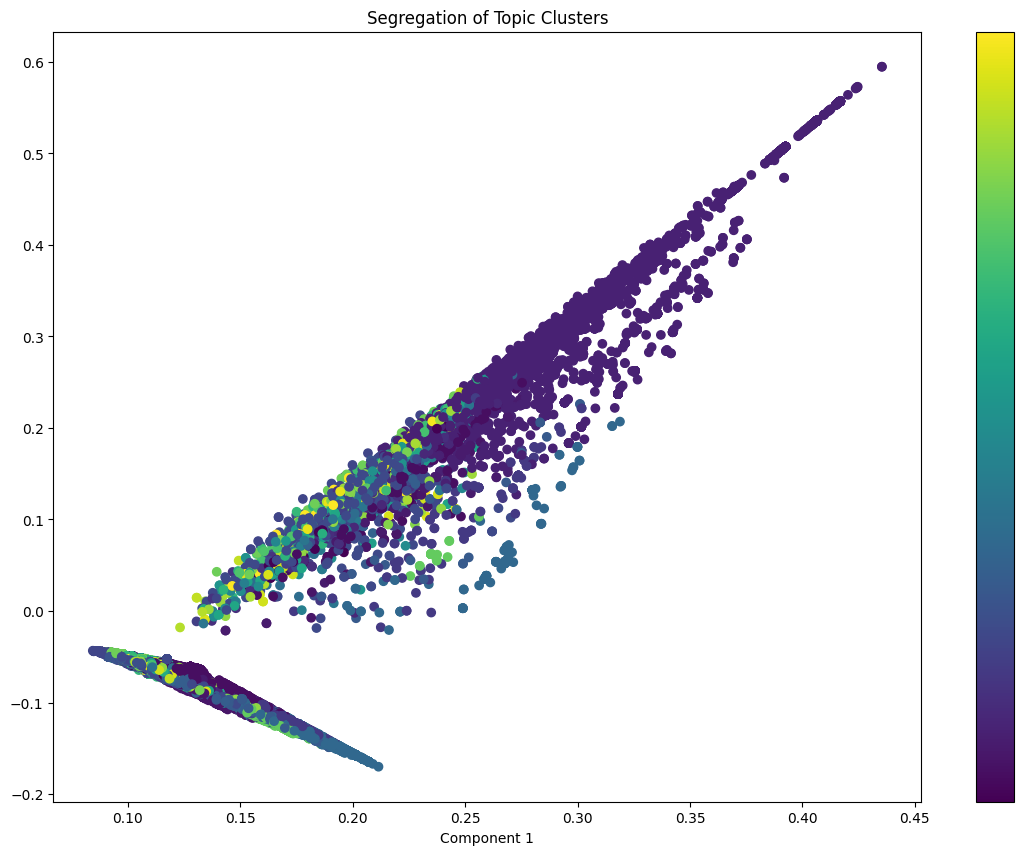

In [54]:
# Plot
plt.figure(figsize=(14, 10))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.colorbar(ticks=[])

In [55]:
import pyLDAvis.lda_model

In [56]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model,train_data,tfidf)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.311617 -0.033814       1        1  3.826642
35     0.299017 -0.071740       2        1  3.049870
24     0.302913 -0.074420       3        1  2.846616
30     0.211876  0.007761       4        1  2.674790
50    -0.063353 -0.164917       5        1  2.383581
22    -0.029948 -0.095511       6        1  2.290594
9      0.144052 -0.012197       7        1  2.088634
11     0.219677 -0.059126       8        1  2.056073
18    -0.087594  0.118335       9        1  2.047429
13    -0.110897  0.059593      10        1  2.032282
29     0.114126 -0.114228      11        1  2.016998
6      0.174762  0.013899      12        1  1.945764
0     -0.038601 -0.247895      13        1  1.937409
49     0.054379  0.030836      14        1  1.929351
39     0.120546  0.047518      15        1  1.913302
5      0.007647  0.082147      16        1  1.908332
42    -0.105488 -0.021688      17        1  1.889182
40    -0.054809  0.114623      18        1  1.885266
38    -0.153670 -0.000972      19        1  1.857321
53     0.015090 -0.056365      20        1  1.846415
52    -0.171301 -0.198678      21        1  1.841749
33     0.004838 -0.063162      22        1  1.839793
44    -0.111115 -0.096115      23        1  1.816177
34     0.018322  0.027602      24        1  1.807573
14    -0.030795 -0.061544      25        1  1.784167
31    -0.026163  0.107336      26        1  1.775525
43     0.203322  0.009472      27        1  1.740539
47     0.075221  0.098785      28        1  1.738865
28    -0.105891 -0.168077      29        1  1.725787
19     0.037781  0.103026      30        1  1.676879
36     0.019430  0.039287      31        1  1.660975
21    -0.022037 -0.051622      32        1  1.647217
32    -0.070356  0.094319      33        1  1.641371
20    -0.032037 -0.037031      34        1  1.639689
54    -0.152399 -0.203375      35        1  1.609313
37    -0.042372 -0.058151      36        1  1.608790
16    -0.087356  0.131725      37        1  1.608038
45    -0.077938  0.147620      38        1  1.603352
4      0.070863  0.032285      39        1  1.601469
25    -0.090337  0.104614      40        1  1.578236
15    -0.059008  0.182532      41        1  1.575308
27    -0.008116  0.076043      42        1  1.570718
46     0.072895  0.076397      43        1  1.565103
26    -0.109455  0.113912      44        1  1.534206
12    -0.004482  0.143636      45        1  1.525663
10     0.032894  0.030617      46        1  1.477685
48    -0.080067  0.092514      47        1  1.468831
1     -0.015699  0.012792      48        1  1.465510
2     -0.053121  0.028131      49        1  1.441318
7     -0.130249 -0.062383      50        1  1.404807
8     -0.064199 -0.093181      51        1  1.399671
51    -0.126150 -0.072738      52        1  1.350097
41    -0.074451 -0.020805      53        1  1.330000
3     -0.039070 -0.058708      54        1  1.284423
23    -0.082742  0.071088      55        1  1.235304, topic_info=        Term         Freq        Total Category  logprob  loglift
188     help  2014.000000  2014.000000  Default  30.0000  30.0000
318  prayers  1543.000000  1543.000000  Default  29.0000  29.0000
321  praying  1480.000000  1480.000000  Default  28.0000  28.0000
78      come  1178.000000  1178.000000  Default  27.0000  27.0000
5     affect  2000.000000  2000.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
170      get    23.513717  2027.491908  Topic55  -4.5461  -0.0631
33       bad    14.249617  1235.042256  Topic55  -5.0470  -0.0683
298   people    16.414729  1908.812446  Topic55  -4.9055  -0.3622
246     make    12.250474  1519.953030  Topic55  -5.1981  -0.4270
231     like    11.469025  1124.785057  Topic55  -5.2640  -0.1918

[1914 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         5  0.046676        10
0        3

In [57]:
pyLDAvis.save_html(vis, 'lda.html')

## Auxiliary Testing

In [58]:
# # Define the number of topics or components
# num_components=10

# # Create LDA object
# model=LatentDirichletAllocation(n_components=num_components)

# # Fit and Transform SVD model on data
# lda_matrix = model.fit_transform(train_data)

# # Get Components 
# lda_components=model.components_

In [59]:
# Print the topics with their terms
# terms = tfidf.get_feature_names_out()

# for index, component in enumerate(lda_components):
#     zipped = zip(terms, component)
#     top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
#     top_terms_list=list(dict(top_terms_key).keys())
#     print("Topic "+str(index)+": ",top_terms_list)